In [41]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)

import tensorflow.keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py

from keras import callbacks 
from sklearn.model_selection import KFold

In [42]:
# load data -------------------------------------------------

num = 4000 # number of profiles
nchan = 3 # number of channels

# get spatial dimension
fname = "Out1/profile_%05d.hdf5" %(1)
hf = h5py.File(fname, 'r')
spatial = hf.get('x') # HDF5 dataset "x": shape (4096,), type "<f8">
x = np.array(spatial) #change it to np array
x_size = np.size(np.array(spatial)) #4096; Dimension: (4096,)
hf.close()

data = np.empty((num, x_size, nchan+1), dtype=float)
for i in range(0, num):
    fname = "Out1/profile_%05d.hdf5" %(i+1)
    hf = h5py.File(fname, 'r')
    data[i, :, 0] = np.array(hf.get("red"))
    data[i, :, 1] = np.array(hf.get("grn"))
    data[i, :, 2] = np.array(hf.get("blu"))
    data[i, :, 3] = np.array(hf.get("tau")) #data.shape: (4000, 4096, 4) 4000 profiles, 4096 pixels, 3 channels 
    hf.close()

np.random.seed(4); #same set of numbers will appear every time
np.random.shuffle(data) #number will be in the same order in data

# allocate for training and testing -------------------------
trp = 0.8; # percent to train and validate
train_size=int(trp*num)
test_size = num - train_size 

# spatial slicing dimensions
os = 8 # output slice size
halo = 2; # edge cells
ts = os + halo * 2 # total input slice size including halos 12
ks = int(ts / 2) # kernel size is half of total size 6
l2r = 511; # number of slices in one profile 



In [43]:
image=np.zeros((l2r*num,ts,3)) 
label=np.zeros((l2r*num,os)) 
for i in range(l2r):
    for n in range(l2r):
        img= data[i,n*os:n*os+ts, 0:nchan] #input: 12 pixels for one slice, 3 channels 
        lb = data[i,n*os+halo:n*os+halo+os, nchan] #8 pixels for label,the tau channel is the label
        image[i*l2r+n]=img
        label[i*l2r+n]=lb 
print('whole dataset features size: ',image.shape,'whole dataset label size: ', label.shape) #511*4000=

whole dataset features size:  (2044000, 12, 3) whole dataset label size:  (2044000, 8)


In [44]:
predictions = np.empty((test_size,8)) 
predictions.shape

(800, 8)

In [45]:
# CNN over domain -------------------------------------------


def evaluate_model(train_image, test_image, train_label, test_label):
    
    ltype = 'mean_squared_error'
    type2=tf.keras.metrics.RootMeanSquaredError()
    bsize = 1024
    eps = 2000

    model_m = models.Sequential()
    model_m.add(layers.Conv1D(nchan*100, kernel_size=ks, activation='relu', input_shape=(ts, nchan))) #kernel size 6, 100 filters for each 3 channel
    model_m.add(layers.Conv1D(8, kernel_size=1))#8 filters, kernel size 1
    model_m.add(layers.Dropout(0.5))
    model_m.add(layers.Flatten())
    model_m.add(layers.Dense(os, activation="linear"))#output slice size : 8

    model_m.summary()



    model_m.compile(optimizer='adam',loss=ltype,metrics=[ltype,type2])

    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 50,  
                                                restore_best_weights = True,
                                               verbose=1) 

    history = model_m.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.1875,
                              callbacks =[earlystopping])#validation set(15%)/trainset(80%)=0.1875

    # test and predict ---------------------------------------------

    print('test result')
    results = model_m.evaluate(test_image, test_label)
    predictions=model_m.predict(test_image)
    mse = results[0]
    rmse = results[2]

    return model_m,rmse,mse,history,predictions

In [46]:
n_folds=5

kf = KFold(n_splits=n_folds)
kf.get_n_splits(image)
print(kf)
ratio=int(image.shape[0]/n_folds)
print('ratio:',ratio)
print('train folds data number:',ratio*4)
print('test fold data number:',ratio)


KFold(n_splits=5, random_state=None, shuffle=False)
ratio: 408800
train folds data number: 1635200
test fold data number: 408800


In [47]:
cv_scores=list()
cv_scores2=list()
model_history = list()

count=1
for train_index, test_index in kf.split(image):
    print("TRAIN:", train_index, "TEST:", test_index)
    train_image, test_image = image[train_index], image[test_index]
    train_label, test_label = label[train_index], label[test_index]

    # evaluate model
    model_m,rmse,mse,history,predictions= evaluate_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)

    count+=1


TRAIN: [ 408800  408801  408802 ... 2043997 2043998 2043999] TEST: [     0      1      2 ... 408797 408798 408799]
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 7, 300)            5700      
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 7, 8)              2408      
_________________________________________________________________
dropout_16 (Dropout)         (None, 7, 8)              0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 56)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 456       
Total params: 8,564
Trainable params: 8,564
Non-trainable params: 0
_________________________________________________________________
Ep

Epoch 28/2000
1298/1298 [==============================] - 7s 5ms/step - loss: 0.0000e+00 - mean_squared_error: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_mean_squared_error: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 29/2000
1298/1298 [==============================] - 7s 5ms/step - loss: 0.0000e+00 - mean_squared_error: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_mean_squared_error: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 30/2000
1298/1298 [==============================] - 7s 5ms/step - loss: 0.0000e+00 - mean_squared_error: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_mean_squared_error: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 31/2000
1298/1298 [==============================] - 7s 5ms/step - loss: 0.0000e+00 - mean_squared_error: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - val_loss: 0.0000e+00 - val_mean_squared_error: 0

Epoch 3/2000
1298/1298 [==============================] - 7s 5ms/step - loss: 4.7050 - mean_squared_error: 4.7050 - root_mean_squared_error: 2.1687 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_root_mean_squared_error: 0.0403
Epoch 4/2000
1298/1298 [==============================] - 7s 5ms/step - loss: 4.6081 - mean_squared_error: 4.6081 - root_mean_squared_error: 2.1465 - val_loss: 7.3523e-05 - val_mean_squared_error: 7.3523e-05 - val_root_mean_squared_error: 0.0086
Epoch 5/2000
1298/1298 [==============================] - 7s 5ms/step - loss: 4.5468 - mean_squared_error: 4.5468 - root_mean_squared_error: 2.1321 - val_loss: 8.8918e-04 - val_mean_squared_error: 8.8918e-04 - val_root_mean_squared_error: 0.0298
Epoch 6/2000
1298/1298 [==============================] - 7s 5ms/step - loss: 4.5571 - mean_squared_error: 4.5571 - root_mean_squared_error: 2.1344 - val_loss: 3.0851e-04 - val_mean_squared_error: 3.0851e-04 - val_root_mean_squared_error: 0.0176
Epoch 7/2000
1298/1298 [

Epoch 37/2000
1298/1298 [==============================] - 7s 5ms/step - loss: 4.2948 - mean_squared_error: 4.2948 - root_mean_squared_error: 2.0723 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_root_mean_squared_error: 0.0403
Epoch 38/2000
1298/1298 [==============================] - 7s 5ms/step - loss: 4.2325 - mean_squared_error: 4.2325 - root_mean_squared_error: 2.0572 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_root_mean_squared_error: 0.0676
Epoch 39/2000
1298/1298 [==============================] - 7s 5ms/step - loss: 4.2418 - mean_squared_error: 4.2418 - root_mean_squared_error: 2.0595 - val_loss: 1.9168e-04 - val_mean_squared_error: 1.9168e-04 - val_root_mean_squared_error: 0.0138
Epoch 40/2000
1298/1298 [==============================] - 7s 5ms/step - loss: 4.2320 - mean_squared_error: 4.2320 - root_mean_squared_error: 2.0568 - val_loss: 3.0095e-04 - val_mean_squared_error: 3.0095e-04 - val_root_mean_squared_error: 0.0173
Epoch 41/2000
1298/1298 [===

Epoch 71/2000
1298/1298 [==============================] - 7s 5ms/step - loss: 3.9463 - mean_squared_error: 3.9463 - root_mean_squared_error: 1.9862 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_root_mean_squared_error: 0.0535
Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping
test result
12775/12775 [==============================] - 27s 2ms/step - loss: 6.6412e-06 - mean_squared_error: 6.6412e-06 - root_mean_squared_error: 0.0026
MSE on test set in fold511 : 6.641200798185309e-06
RMSE on test set in fold511 : 0.0025770526845008135
TRAIN: [      0       1       2 ... 2043997 2043998 2043999] TEST: [ 817600  817601  817602 ... 1226397 1226398 1226399]
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 7, 300)            5700      
_________________________________________________________________
conv1d_3

Epoch 28/2000
1298/1298 [==============================] - 7s 5ms/step - loss: 4.4095 - mean_squared_error: 4.4095 - root_mean_squared_error: 2.0996 - val_loss: 2.9179e-04 - val_mean_squared_error: 2.9179e-04 - val_root_mean_squared_error: 0.0171
Epoch 29/2000
1298/1298 [==============================] - 7s 5ms/step - loss: 4.3211 - mean_squared_error: 4.3211 - root_mean_squared_error: 2.0785 - val_loss: 1.5644e-04 - val_mean_squared_error: 1.5644e-04 - val_root_mean_squared_error: 0.0125
Epoch 30/2000
1298/1298 [==============================] - 7s 5ms/step - loss: 4.3313 - mean_squared_error: 4.3313 - root_mean_squared_error: 2.0809 - val_loss: 6.8253e-05 - val_mean_squared_error: 6.8253e-05 - val_root_mean_squared_error: 0.0083
Epoch 31/2000
1298/1298 [==============================] - 6s 5ms/step - loss: 4.3859 - mean_squared_error: 4.3859 - root_mean_squared_error: 2.0927 - val_loss: 5.6584e-05 - val_mean_squared_error: 5.6584e-05 - val_root_mean_squared_error: 0.0075
Epoch 32/200

Epoch 62/2000
1298/1298 [==============================] - 6s 5ms/step - loss: 3.9345 - mean_squared_error: 3.9345 - root_mean_squared_error: 1.9835 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_root_mean_squared_error: 0.0574
Epoch 63/2000
1298/1298 [==============================] - 6s 5ms/step - loss: 3.9411 - mean_squared_error: 3.9411 - root_mean_squared_error: 1.9850 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_root_mean_squared_error: 0.0930
Epoch 64/2000
1298/1298 [==============================] - 7s 5ms/step - loss: 3.8483 - mean_squared_error: 3.8483 - root_mean_squared_error: 1.9616 - val_loss: 6.3820e-04 - val_mean_squared_error: 6.3820e-04 - val_root_mean_squared_error: 0.0253
Epoch 65/2000
1298/1298 [==============================] - 6s 5ms/step - loss: 3.9300 - mean_squared_error: 3.9300 - root_mean_squared_error: 1.9823 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_root_mean_squared_error: 0.1112
Epoch 66/2000
1298/1298 [===========

Epoch 13/2000
1298/1298 [==============================] - 7s 5ms/step - loss: 4.5742 - mean_squared_error: 4.5742 - root_mean_squared_error: 2.1385 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_root_mean_squared_error: 0.0521
Epoch 14/2000
1298/1298 [==============================] - 6s 5ms/step - loss: 4.5743 - mean_squared_error: 4.5743 - root_mean_squared_error: 2.1384 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_root_mean_squared_error: 0.0826
Epoch 15/2000
1298/1298 [==============================] - 6s 5ms/step - loss: 4.6216 - mean_squared_error: 4.6216 - root_mean_squared_error: 2.1497 - val_loss: 2.2515e-04 - val_mean_squared_error: 2.2515e-04 - val_root_mean_squared_error: 0.0150
Epoch 16/2000
1298/1298 [==============================] - 6s 5ms/step - loss: 4.4369 - mean_squared_error: 4.4369 - root_mean_squared_error: 2.1062 - val_loss: 2.5316e-04 - val_mean_squared_error: 2.5316e-04 - val_root_mean_squared_error: 0.0159
Epoch 17/2000
1298/1298 [===

Epoch 47/2000
1298/1298 [==============================] - 6s 5ms/step - loss: 3.9631 - mean_squared_error: 3.9631 - root_mean_squared_error: 1.9902 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_root_mean_squared_error: 0.0939
Epoch 48/2000
1298/1298 [==============================] - 6s 5ms/step - loss: 4.0273 - mean_squared_error: 4.0273 - root_mean_squared_error: 2.0064 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_root_mean_squared_error: 0.0770
Epoch 49/2000
1298/1298 [==============================] - 6s 5ms/step - loss: 3.9768 - mean_squared_error: 3.9768 - root_mean_squared_error: 1.9936 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_root_mean_squared_error: 0.0580
Epoch 50/2000
1298/1298 [==============================] - 7s 5ms/step - loss: 4.0696 - mean_squared_error: 4.0696 - root_mean_squared_error: 2.0171 - val_loss: 0.0531 - val_mean_squared_error: 0.0531 - val_root_mean_squared_error: 0.2303
Epoch 51/2000
1298/1298 [===================

Epoch 24/2000
1298/1298 [==============================] - 6s 5ms/step - loss: 4.3867 - mean_squared_error: 4.3867 - root_mean_squared_error: 2.0943 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_root_mean_squared_error: 0.0796
Epoch 25/2000
1298/1298 [==============================] - 6s 5ms/step - loss: 4.2121 - mean_squared_error: 4.2121 - root_mean_squared_error: 2.0522 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - val_root_mean_squared_error: 0.0435
Epoch 26/2000
1298/1298 [==============================] - 6s 5ms/step - loss: 4.3754 - mean_squared_error: 4.3754 - root_mean_squared_error: 2.0913 - val_loss: 9.1741e-05 - val_mean_squared_error: 9.1741e-05 - val_root_mean_squared_error: 0.0096
Epoch 27/2000
1298/1298 [==============================] - 6s 5ms/step - loss: 4.2285 - mean_squared_error: 4.2285 - root_mean_squared_error: 2.0559 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_root_mean_squared_error: 0.1067
Epoch 28/2000
1298/1298 [===========

1298/1298 [==============================] - 7s 5ms/step - loss: 3.9035 - mean_squared_error: 3.9035 - root_mean_squared_error: 1.9753 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_root_mean_squared_error: 0.1574
Epoch 59/2000
1298/1298 [==============================] - 6s 5ms/step - loss: 3.9667 - mean_squared_error: 3.9667 - root_mean_squared_error: 1.9901 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_root_mean_squared_error: 0.1556
Epoch 60/2000
1298/1298 [==============================] - 7s 5ms/step - loss: 3.8042 - mean_squared_error: 3.8042 - root_mean_squared_error: 1.9503 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_root_mean_squared_error: 0.0701
Epoch 61/2000
1298/1298 [==============================] - 6s 5ms/step - loss: 3.8269 - mean_squared_error: 3.8269 - root_mean_squared_error: 1.9562 - val_loss: 6.4422e-04 - val_mean_squared_error: 6.4422e-04 - val_root_mean_squared_error: 0.0254
Epoch 62/2000
1298/1298 [=========================

In [37]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

Estimated MSE 13.7596 with standard deviation (27.5191)
Estimated RMSE 1.6611 with standard deviation (3.3167)


In [38]:
predictions.shape

(408800, 8)

In [39]:
cv_scores

[68.79788208007812,
 5.174631496629445e-06,
 5.447053808893543e-06,
 8.164126484189183e-06,
 1.4631928024755325e-05]

In [40]:
cv_scores2

[8.294448852539062,
 0.002274781698361039,
 0.00233389250934124,
 0.0028572934679687023,
 0.0038251702208071947]

The optimal number of epochs is 219 in the last fold.


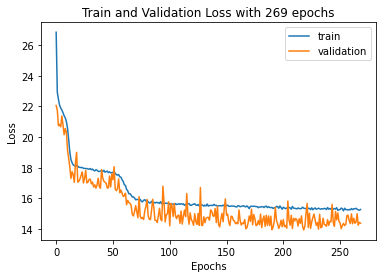

In [19]:
patience=50
# plot training and validation history in the last fold
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+' epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience)+' in the last fold.')


In [20]:
predict3=np.zeros((l2r,8))

for i in range(408289,408800):
    predict3[i-408289]=predictions[i]
    
predict2=np.zeros((l2r,8))

for i in range(407778,408289):
    predict2[i-407778]=predictions[i]
    
predict1=np.zeros((l2r,8))

for i in range(407267,407778):
    predict1[i-407267]=predictions[i]

In [21]:
ltype = 'mean_squared_error'
ltype2=tf.keras.metrics.RootMeanSquaredError()
bsize = 1024

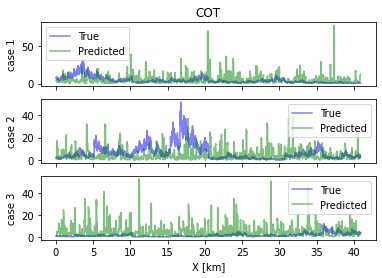

In [22]:
# plotting ------------------------------------------------------
fgnm = "predict"+"_"+str(ltype)+"_"+str(bsize)+"_"+str(len(history.history['val_loss'])-patience)+'DNN connection patience50'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"COT")
ax.plot(x[halo:os*l2r+halo],data[num-3,halo:os*l2r+halo,3].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo],predict1.reshape(4088),alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[halo:os*l2r+halo],data[num-2,halo:os*l2r+halo,3].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo],predict2.reshape(4088),alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[halo:os*l2r+halo],data[num-1,halo:os*l2r+halo,3].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo],predict3.reshape(4088),alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

In [ ]:
# plotting ------------------------------------------------------
fgnm = "predict"+"_"+str(ltype)+"_"+str(bsize)+"_"+str(len(history.history['val_loss'])-patience)+"_first_80_pixels_DNN patience50"
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the first 80 pixels in last three test images

#plot the third last profile
ax = axs[0]
ax.set_title(r"COT")
ax.plot(x[halo:os*l2r+halo][:80],data[num-3,halo:os*l2r+halo,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[halo:os*l2r+halo][:80],predict1.reshape(4088)[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[halo:os*l2r+halo][:80],data[num-2,halo:os*l2r+halo,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[halo:os*l2r+halo][:80],predict2.reshape(4088)[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[halo:os*l2r+halo][:80],data[num-1,halo:os*l2r+halo,3][:80].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo][:80],predict3.reshape(4088)[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')